# Final Project Foundamentals of Data Science
### Solar Eclipse phases classification
#### Luca Moresca, Nicholas Suozzi, Valerio Santini

---------
-   **Titolo del progetto:** Classificazione delle fasi dell'eclissi solare 
-   **Autori:** Luca Moresca, Nicholas Suozzi, Valerio Santini
-   **Descrizione del problema:** Fornire una breve panoramica del problema della classificazione delle fasi dell'eclissi solare. Evidenziare l'importanza dello studio delle eclissi solari per la comprensione dell'interazione tra Sole e Terra.
-   **Obiettivo del progetto:** Definire chiaramente l'obiettivo del progetto, ovvero sviluppare un modello in grado di classificare accuratamente le diverse fasi di un'eclissi solare da immagini.


### Abstract


In [51]:
if True:
    %pip install -qqq numpy scipy matplotlib pandas scikit-learn seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


In [52]:
%matplotlib inline
import os
import json
import time
import cv2
import random
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import convolve1d
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from typing import List, Tuple, Optional, Dict, Union
from concurrent.futures import ThreadPoolExecutor
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Usefull for histograms, taken from homework 1

def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def plot_pictures(
    imgs: List[np.ndarray],
    xlabels: List[str],
    nrows: int,
    ncols: int,
    show: bool = True,
    cmap: Union[str, List[str]] = "gray",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    same_scale: bool = False,
) -> List[plt.Axes]:
    fig, axs = plt.subplots(nrows, ncols,
                            width_ratios=[img.shape[1] / img.shape[0] for img in imgs],
                            sharey=same_scale,
                            figsize=(ncols * 4, nrows * 4))
    axs = axs.flatten()

    for i, (img, ax) in enumerate(zip(imgs, axs)):
        if isinstance(cmap, list):
            current_cmap = cmap[i]
        else:
            current_cmap = cmap
        im = ax.imshow(img, cmap=current_cmap, vmin=vmin, vmax=vmax)


        ax.set_title(xlabels[i])
        ax.axis('off')
    plt.tight_layout()

    if show:
        plt.show()
    else:
        return axs

## 1. Dataset Analysis

The “Great American Eclipse” in 2017 offered a unique opportunity for US citizens across the entire continent to experience the awe-inspiring changes that occur during rare total solar eclipses (TSEs). The goal of the 2017 Eclipse Megamovie was to obtain enough pictures of the Great American Total Solar Eclipse to create a movie of the solar corona in order to better study it. Over 2,000 volunteers submitted 50,000 images and a movie was made only a few hours after the Moon's shadow left the U.S. A few months later another, better aligned and more closely edited, movie was released. The Eclipse Megamovie team of scientists processed images to create High Dynamic Range (HDR) images to capture the structures within the high dynamic range of the solar corona from the Sun's photosphere out ~3 solar radii.
https://eclipsemegamovie.org

Eclipse megamovie is a project being carried out by a group of researchers in collaboration with NASA. The focus of this project is to make a video that can facilitate research into a rare event such as the eclipse that occurred in the United States in 2017. To realise this project, American citizens were asked to send in photographs taken during the eclipse. The dataset therefore contains semi-professional and amateur images, taken under conditions that are not always optimal.

In [54]:
with open('eclipse-megamovie/label_num_to_phase_map.json', 'r') as file:
    data = json.load(file)
print(json.dumps(data, indent=4))

{
    "TotalSolarEclipse": 0,
    "0to25percentPartialEclipse": 1,
    "26to55percentPartialEclipse": 2,
    "56to95percentPartialEclipse": 3,
    "Darks": 4,
    "DiamondRing_BaileysBeads_SolarEclipse": 5,
    "Flats": 6,
    "NotASolarEclipse": 7
}


In [55]:
df = pd.read_csv("eclipse-megamovie/train.csv")
print(df)

                                              image_id  label
0    0089d49c892b6d15513690521c08eb5ffc93fe24a4926c...      0
1    00ade9976af2090eae8e6e5eed3096f12dc7235adb3c12...      0
2    ff6c7fea709fd7bbb1790668dc664b30ed72cfb2cae0a0...      0
3    eee7f9abf29297179aa070518671bfc9a60c9f8a67e62a...      0
4    fcc12656dacc1867bbea8438635bf52b4b1920cac3e48b...      0
..                                                 ...    ...
490  4f99a8e1efe0a51fca127bcdabfb1165523dee8730dbba...      7
491  fb9026a6d96719729ef44c61e76c5b007b17784f6ddb8f...      7
492  0160498b80fcf8f55002627f1f3eb7c6969675f7877410...      7
493  021c7d3386821090186bd925a8d13d9cc509db69550956...      7
494  018b72bf1ef4f3a184c0029ffcff3dde17f4a883ef472f...      7

[495 rows x 2 columns]


The .json file relates the eclipse phases to the corresponding labels in the ‘train.csv’ file, which will help the training phase by already having a correspondence between label and image. The csv file then contains a classification of the various training images useful for the model. 

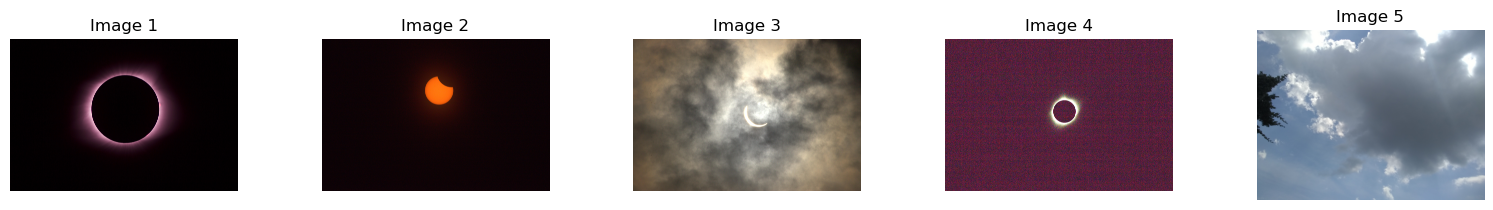

In [56]:
img1 = mpimg.imread('eclipse-megamovie/train/00a0f91f0e7ece88ebaeab2a2050cdc0d72c5ea0b56c601dfaf800077df44c51.jpg')
img2 = mpimg.imread('eclipse-megamovie/train/00a4af4cc3f2a667c80331051a733e8dae2477d682d7dcef3e895f6f923dd86a.jpg')
img3 = mpimg.imread('eclipse-megamovie/train/00c11b16fd6426a88039c8b27e2511e2e770b65e0eb9daab720d3e6ca996bc06.jpg')
img4 = mpimg.imread('eclipse-megamovie/train/001e6704a60798684f1656713b593e6a56de81474e7173a31936589cd62f13e8.jpg')
img5 = mpimg.imread('eclipse-megamovie/train/4f99a8e1efe0a51fca127bcdabfb1165523dee8730dbba0df5436a7de70dc16e.jpg')

fig, axes = plt.subplots(1, 5, figsize=(16, 4))
fig.tight_layout(pad=3.0)

axes[0].imshow(img1)
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title("Image 2")
axes[1].axis('off')

axes[2].imshow(img3)
axes[2].set_title("Image 3")
axes[2].axis('off')

axes[3].imshow(img4)
axes[3].set_title("Image 4")
axes[3].axis('off')

axes[4].imshow(img5)
axes[4].set_title("Image 5")
axes[4].axis('off')

plt.show()

* As can be seen in the figure above, our dataset consists of various types of images. Some contain eclipses, others do not. The images have different perspectives, are taken with different devices and have different backgrounds. 
This presents us with the challenge of correctly identifying the content of each image accurately, we must be able to classify images that do not contain eclipses as impostors. 
On a numerical level, the dataset consists of a training set and a test set. In addition, there is a .csv file containing the name of some images and a label showing the corresponding eclipse phase. In addition, there is a .json file that explains what each label corresponds to on a phase level. 
There are 496 images in the training set and 140 images in the test set. The dataset is restricted and this will result in an appropriate treatment of the images to improve the performance of the model. 

* Each image has a different resolution, considering that they are obtained with various devices. The eclipse within each image is not always perfectly sharp or centred, making the model more elastic in various cases.


## 2. Preprocessing delle immagini

-   **Spiegazioni:** Descrivere le tecniche di preprocessing delle immagini utilizzate, spiegando la logica alla base di ogni scelta.
-   Ad esempio, se si ridimensionano le immagini, spiegare perché è necessario farlo e quale dimensione si è scelto di utilizzare.
-   Se si convertono le immagini in scala di grigi, giustificare questa scelta.
-   Se si normalizzano i valori dei pixel, spiegare il metodo di normalizzazione utilizzato e perché è importante.
-   **Codice:** Fornire il codice Python utilizzato per il preprocessing delle immagini.
-   **Visualizzazioni:** Mostrare alcuni esempi di immagini pre-elaborate, confrontandole con le immagini originali.


### Suggerimenti per il Preprocessing delle Immagini per la Classificazione delle Fasi di Eclissi Solare

Ecco alcuni suggerimenti per descrivere le tecniche di preprocessing delle immagini che potresti utilizzare per il tuo progetto di classificazione delle fasi di eclissi solare, insieme alla logica alla base di ogni scelta:

*   **Conversione in scala di grigi:** La conversione delle immagini in scala di grigi è una scelta comune nel preprocessing delle immagini, soprattutto quando il colore non è una caratteristica discriminante per il compito in questione. Nel caso della classificazione delle fasi di eclissi solare, le informazioni di colore potrebbero non essere essenziali per distinguere le diverse fasi. La conversione in scala di grigi riduce la complessità dei dati e la quantità di informazioni da elaborare, il che può accelerare i tempi di addestramento del modello e potenzialmente migliorare le sue prestazioni.
*   **Riduzione del rumore:** Le immagini possono contenere rumore che può influenzare negativamente le prestazioni del modello. La riduzione del rumore può essere realizzata utilizzando filtri come il filtro gaussiano.  Applicare un filtro gaussiano prima di altre operazioni di preprocessing può aiutare a migliorare la qualità delle immagini e a rendere più evidenti le caratteristiche importanti per la classificazione.
*   **Downscaling:**  Se le immagini originali hanno una risoluzione molto alta, il downscaling può essere utile per ridurre la quantità di dati da elaborare e accelerare i tempi di addestramento. La dimensione da utilizzare dipenderà dalla risoluzione originale delle immagini e dalla complessità del modello. È importante scegliere una dimensione che conservi le caratteristiche essenziali per la classificazione, evitando al contempo di perdere troppe informazioni.  Assicurati di applicare un filtro gaussiano prima del downscaling per evitare l'aliasing. 
*   **Normalizzazione:** La normalizzazione dei valori dei pixel è un'altra tecnica comune nel preprocessing delle immagini.  Può essere eseguita sottraendo la media e dividendo per la deviazione standard dei valori dei pixel. Questo processo porta tutti i valori dei pixel in un intervallo simile, il che può aiutare a migliorare le prestazioni del modello, soprattutto quando si utilizzano algoritmi di apprendimento automatico sensibili alla scala dei dati.

**Tecniche utili dagli homework:**

*   **Dal Homework 1:** Tutte le tecniche elencate (riduzione del rumore, downscaling, normalizzazione e conversione in scala di grigi) possono essere utili per il tuo progetto.
*   **Dal Homework 2:** La codifica one-hot sarà necessaria per le etichette delle fasi dell'eclissi. La gestione dei valori mancanti potrebbe essere utile se il tuo set di dati contiene immagini incomplete o danneggiate. L'espansione polinomiale e lo scaling potrebbero non essere necessari per il tuo progetto, in quanto sono tecniche più comunemente utilizzate per dati numerici non immagine.

### Tecniche Essenziali di Preprocessing per Immagini di Eclissi Solari Variabili

Dato che si ha a che fare con una vasta gamma di immagini scattate da amatori, che presentano diverse proporzioni, dimensioni del sole e posizioni del sole all'interno dell'immagine, è fondamentale applicare tecniche di preprocessing essenziali per preparare i dati per l'addestramento del modello di classificazione delle fasi dell'eclissi. 

Oltre alle tecniche di base già discusse (conversione in scala di grigi, riduzione del rumore, downscaling e normalizzazione), ecco alcune altre tecniche molto essenziali da considerare:

*   **Ritaglio e ridimensionamento:** Le immagini potrebbero avere bordi o aree irrilevanti che non contribuiscono alla classificazione delle fasi dell'eclissi. Il ritaglio può essere utilizzato per rimuovere queste aree e focalizzare l'attenzione sulla regione di interesse, ovvero il sole e la corona solare. Dopo il ritaglio, tutte le immagini dovrebbero essere ridimensionate a una dimensione uniforme per garantire la compatibilità con il modello. Poiché le proporzioni delle immagini originali possono variare, è possibile utilizzare un ridimensionamento con padding per mantenere le proporzioni originali, aggiungendo bordi neri attorno all'immagine ritagliata per raggiungere la dimensione desiderata. 
*   **Centratura del Sole:** La posizione del sole all'interno dell'immagine può variare notevolmente. Per migliorare le prestazioni del modello, è utile centrare il sole in tutte le immagini. Ciò può essere ottenuto tramite algoritmi di rilevamento degli oggetti o, in casi più semplici, analizzando l'istogramma dell'immagine per identificare la regione più luminosa (presumibilmente il sole) e spostarla al centro dell'immagine.

### Come Rilevare e Centrare il Sole nelle Immagini di Eclissi

Per centrare il sole in un'immagine, un metodo robusto è quello di utilizzare la **combinazione di rilevamento dei bordi, piramide gaussiana e template matching**, tecniche già presenti negli homework forniti.

**Ecco i passaggi**

1. **Rilevamento dei Bordi**

2. **Piramide Gaussiana** 

3. **Template Matching** 

4. **Selezione della Scala Migliore** 

5. **Centratura** 

**Note Aggiuntive**

* Per migliorare ulteriormente la precisione del rilevamento, è possibile utilizzare un template del sole più sofisticato, che tenga conto della corona solare.
* Dopo la centratura, potrebbe essere necessario ritagliare l'immagine per rimuovere eventuali bordi neri aggiunti durante il ridimensionamento con padding.

Questo metodo offre una soluzione efficace per rilevare e centrare il sole in immagini di eclissi solare, utilizzando tecniche già familiari dagli homework e garantendo una buona robustezza e flessibilità.




### Conversione in scala di grigi 

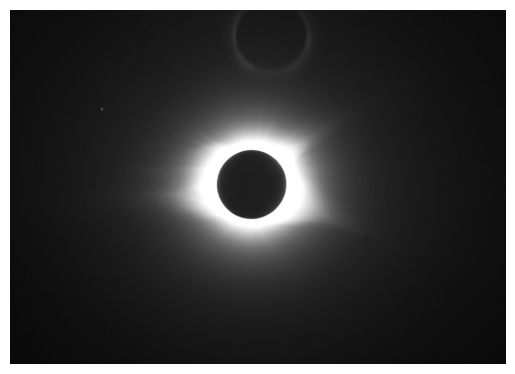

In [57]:
path = "eclipse-megamovie/train/00a8e42aff446cd530533d7f45a92c28c2880c4576f9fb6869b768dfb0109942.jpg"
image = cv2.imread(path)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, cmap="gray")
plt.axis('off')
plt.show()

### Denoising

In [58]:
def gauss(sigma: float, filter_size: int) -> Tuple[np.ndarray, np.ndarray]:
    Gx = np.array([])
    k = (filter_size - 1) // 2  
    x = np.arange(-k, k + 1)
    cost = 1/(np.sqrt(2*np.pi)*sigma)
    Gx = np.append(Gx, cost * np.exp(-(x**2)/(2*sigma**2)))
    return Gx, x

def gaussfiltering(img: np.ndarray, sigma: float) -> np.ndarray:
    filter_size = np.round(6 * sigma)

    Gx, _ = gauss(sigma, filter_size)
    out = convolve1d(img, Gx, axis = 1)
    out = convolve1d(out, Gx, axis = 0)
    
    return out

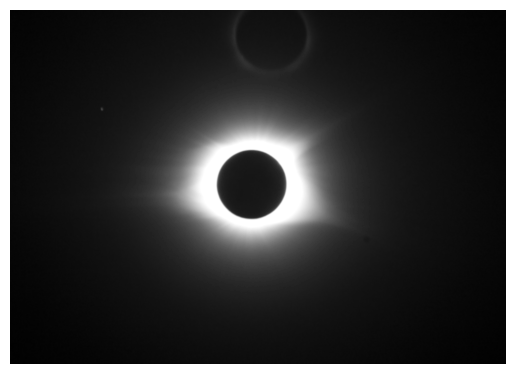

In [59]:
sigma = 3

smt_img = gaussfiltering(gray_image, sigma)

plt.imshow(smt_img, cmap="gray")
plt.axis('off')
plt.show()

COMMENTARE


### Normalization

The normalize function performs linear normalization of an image to scale pixel values in the range $[0,1]$

In [60]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

In [61]:
nrm_img = normalize(smt_img)

### Eclipse Isolation

In [62]:
def detect_eclipse(image):
    offset = 128
    intensity_threshold = threshold_otsu(image)
    bright_pixels = image > intensity_threshold

    labeled_bright = label(bright_pixels)
    regions = regionprops(labeled_bright)
    
    if len(regions) == 0:
        print("No light regions detected.")
        return None
    largest_region = max(regions, key=lambda r: r.area)
    minr, minc, maxr, maxc = largest_region.bbox

    height = maxr - minr + offset
    width = maxc - minc + offset
    
    side_length = max(height, width)

    center_r = (minr + maxr) // 2
    center_c = (minc + maxc) // 2

    minr = center_r - side_length // 2
    maxr = center_r + side_length // 2
    minc = center_c - side_length // 2
    maxc = center_c + side_length // 2
    
    if minr < 0:
        maxr += abs(minr)  
        minr = 0
    if maxr > image.shape[0]:
        minr -= maxr - image.shape[0]
        maxr = image.shape[0]

    if minc < 0:
        maxc += abs(minc)   
        minc = 0
    if maxc > image.shape[1]:
        minc -= maxc - image.shape[1]
        maxc = image.shape[1]

    minr = max(0, minr)
    minc = max(0, minc)
    maxr = min(image.shape[0], maxr)
    maxc = min(image.shape[1], maxc)

    cropped_image = image[minr:maxr, minc:maxc]

    return cropped_image

This function identifies and isolates the brightest region of an image by performing a square crop centered on it. It uses Otsu's threshold method to determine the brightest pixels and then identifies the largest connected region using regionprops. After calculating an extended bounding box with an offset, it determines a square crop based on the longest side of the detected area, centering the crop on the bright region.

If the crop exceeds the boundaries of the image, the edges are corrected to keep the crop within the image itself. In the absence of bright regions, the function returns None.

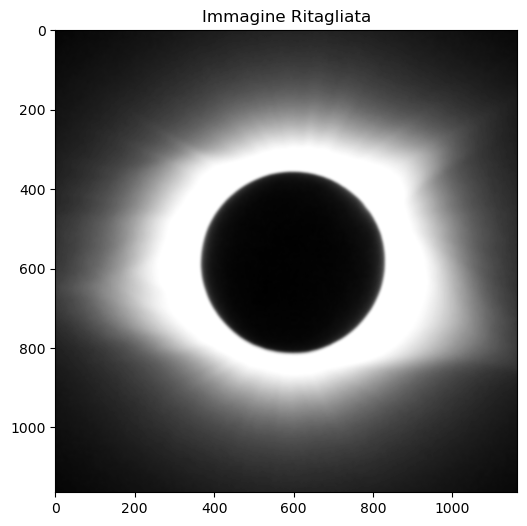

In [63]:
cropped_img = detect_eclipse(nrm_img)

#Print Cropped Img
plt.figure(figsize=(12, 6))
plt.title("Immagine Ritagliata")
plt.imshow(cropped_img, cmap='gray')
plt.show()


### Downscaling

In [64]:
def downscale(
    img: np.ndarray,
    target_resolution: tuple = (512, 512),
    sigma: float = 1
) -> np.ndarray:

    if img.ndim == 3:   
        img_blurred = np.zeros_like(img)
        for c in range(3):
            img_blurred[:, :, c] = gaussfiltering(img[:, :, c], sigma)
    else:   
        img_blurred = gaussfiltering(img, sigma)

    downscaled_img = resize(img_blurred, target_resolution, anti_aliasing=True)

    if img.ndim == 3:  
        downscaled_img = np.clip(downscaled_img * 255, 0, 255).astype(np.uint8)
        img_blurred = np.clip(img_blurred * 255, 0, 255).astype(np.uint8)

    return downscaled_img


The downscale function downscales an image to a specified target resolution, applying Gaussian pre-filtering to reduce artifacts due to sampling.

Main details:

* Accepts an input image (img) and an optional target resolution parameter (target_resolution, default (512, 512)).
* Applies Gaussian filtering (gaussfiltering) to smooth the image before resizing.
* Uses skimage.transform.resize to resize the image, with anti_aliasing option to preserve visual quality.
* Converts filtered and resized images to 8-bit (uint8) format to ensure compatibility and optimize memory.

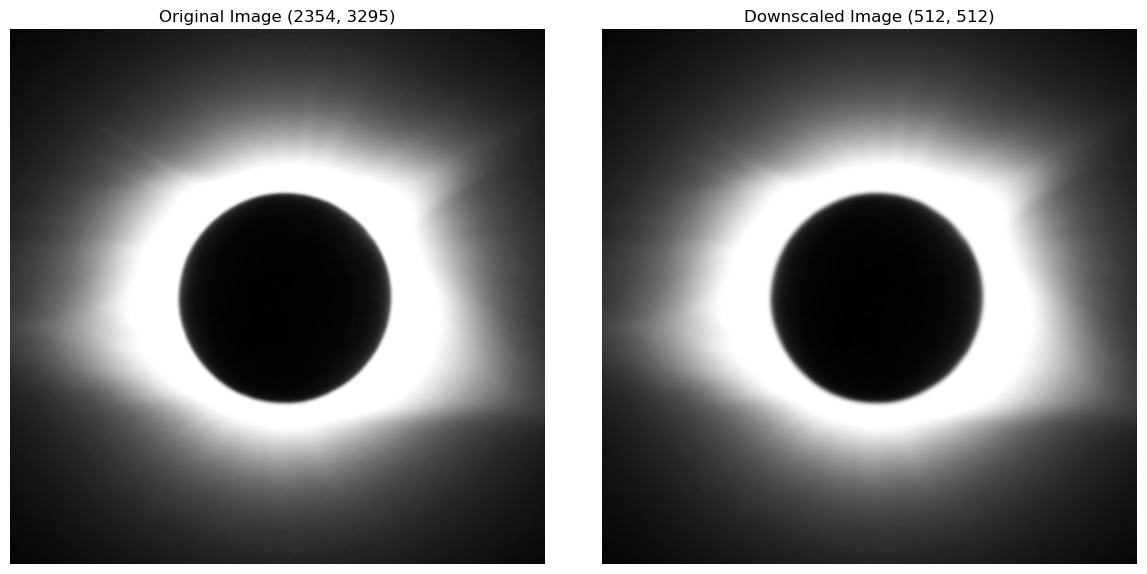

In [65]:
downscaled = downscale(cropped_img, target_resolution=(512, 512), sigma=3)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
plt.gray()
fig.tight_layout()

axes[0].imshow(cropped_img)
axes[0].set_title(f"Original Image {smt_img.shape}")
axes[0].axis('off')
axes[1].imshow(downscaled)
axes[1].set_title(f"Downscaled Image {downscaled.shape}")
axes[1].axis('off')

plt.show()

In [66]:
def preprocess_image(path: str, target_resolution: tuple = (512, 512), sigma: float = 3, offset: int = 128):
    image = cv2.imread(path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    smt_img = gaussfiltering(gray_image, sigma)
    nrm_img = normalize(smt_img)
    cropped_img = detect_eclipse(nrm_img)
    downscaled_img = downscale(cropped_img, target_resolution, sigma)
    downscaled_img *= 255
    return downscaled_img

In [67]:
def get_image_paths(folder_path):
    supported_formats = ('.jpg', '.png')
    return [
        os.path.join(folder_path, filename)
        for filename in os.listdir(folder_path)
        if filename.lower().endswith(supported_formats)
    ]

def preprocess_images_in_parallel(folder_path, output_folder, target_resolution=(512, 512), sigma=3, num_workers=4):
    image_paths = get_image_paths(folder_path)

    def process_and_save(path):
        try:
            preprocessed_image = preprocess_image(path, target_resolution, sigma)
            if preprocessed_image is None:
                print(f"Error in image preprocessing: {path}")
                return
            
            output_path = os.path.join(output_folder, os.path.basename(path))
            success = cv2.imwrite(output_path, preprocessed_image)
            if not success:
                print(f"Error saving image: {output_path}")
        except Exception as e:
            print(f"Error during processing of {path}: {e}")

    os.makedirs(output_folder, exist_ok=True)
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        executor.map(process_and_save, image_paths)
        
        
def preprocess_images_sequentially(folder_path, output_folder, target_resolution=(512, 512), sigma=3):
    image_paths = get_image_paths(folder_path)
    os.makedirs(output_folder, exist_ok=True)
    for path in image_paths:
        try:
            preprocessed_image = preprocess_image(path, target_resolution, sigma)            
            if preprocessed_image is None:
                print(f"Error in image preprocessing: {path}")
                continue
            output_path = os.path.join(output_folder, os.path.basename(path))
            success = cv2.imwrite(output_path, preprocessed_image)
            if not success:
                print(f"Errore nel salvataggio dell'immagine: {output_path}")
        except Exception as e:
            print(f"Error during processing of {path}: {e}")

In [68]:
input_folder_train = "eclipse-megamovie/train"
output_folder_train = "train_preprocessed"
input_folder_test = "eclipse-megamovie/test"
output_folder_test = "test_preprocessed"

target_resolution = (512, 512)
sigma = 3

# Training set parallel preprocessing
print(f"Inizio preprocessing per il training set...")
start_time = time.time()
preprocess_images_in_parallel(input_folder_train, output_folder_train, target_resolution, sigma, num_workers=8)
print(f"Preprocessing del training set completato. Immagini salvate in {output_folder_train}.")
print(f"Tempo con parallelizzazione: {time.time() - start_time:.2f} secondi")

# Training set sequential preprocessing, deliberately left commented to avoid long running times
# start_time = time.time()
# preprocess_images_sequentially(input_folder_train, output_folder_train, target_resolution, sigma)
# print(f"Tempo senza parallelizzazione: {time.time() - start_time:.2f} secondi")

# Test set parallel
print(f"Inizio preprocessing per il test set...")
preprocess_images_in_parallel(input_folder_test, output_folder_test, target_resolution, sigma, num_workers=8)
print(f"Preprocessing del test set completato. Immagini salvate in {output_folder_test}.")


Inizio preprocessing per il training set...


Invalid SOS parameters for sequential JPEG


Preprocessing del training set completato. Immagini salvate in train_preprocessed.
Tempo con parallelizzazione: 105.87 secondi
Inizio preprocessing per il test set...
Preprocessing del test set completato. Immagini salvate in test_preprocessed.


Il preprocessing viene applicato utilizzando la parallelizzazione di Python, (approfondire l'argomento), l'output senza salvare le immagini è questo: 

* Tempo con parallelizzazione: 97.14 secondi (1.6 minuti)
* Tempo senza parallelizzazione: 379.42 secondi (6.31 minuti)

Il test non viene applicato al dataset di test, perchè per convenienza di tempi viene usata solo la parallelizzazione


### Convolutional Neural Network 

In [69]:
class SolarEclipseDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.target_resolution = target_resolution
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx, 0])
        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, self.target_resolution)
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

csv_file = "eclipse-megamovie/train.csv"
image_folder = "train_preprocessed/"
dataset = SolarEclipseDataset(csv_file, image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [70]:
class SolarEclipseCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SolarEclipseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [71]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SolarEclipseCNN(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")
print("Training completed.")

Epoch [1/7], Loss: 1.9450
Epoch [2/7], Loss: 0.9220
Epoch [3/7], Loss: 0.6164
Epoch [4/7], Loss: 0.4087
Epoch [5/7], Loss: 0.3328
Epoch [6/7], Loss: 0.8976
Epoch [7/7], Loss: 0.3860
Training completed.


In [72]:
# Save the trained model 
model_path = "eclipse-megamovie/solar_net.pth"
torch.save(model.state_dict(), model_path)

In [73]:
# model.load_state_dict(torch.load(model_path, weights_only=True))

In [74]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       187
           1       0.91      0.94      0.92        52
           2       1.00      0.76      0.87        38
           3       1.00      0.93      0.96        57
           4       1.00      0.81      0.89        63
           5       0.81      0.98      0.89        44
           6       0.90      1.00      0.95        18
           7       1.00      0.92      0.96        36

    accuracy                           0.94       495
   macro avg       0.94      0.92      0.93       495
weighted avg       0.94      0.94      0.93       495

Confusion Matrix:
[[187   0   0   0   0   0   0   0]
 [  1  49   0   0   0   2   0   0]
 [  1   5  29   0   0   3   0   0]
 [  1   0   0  53   0   3   0   0]
 [ 11   0   0   0  51   0   1   0]
 [  1   0   0   0   0  43   0   0]
 [  0   0   0   0   0   0  18   0]
 [  0   0   0   0   0   2   1  33]]


Now we can try preprocessing with an image given its path

In [75]:
class CustomTestDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_names = [
            f for f in os.listdir(image_folder) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder, img_name)
        try:
            image = Image.open(img_path).convert("L")
        except UnidentifiedImageError:
            print(f"Invalid image: {img_path}")
            return None, img_name

        if self.transform:
            image = self.transform(image)

        return image, img_name

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

image_folder = "train_preprocessed"
test_dataset = CustomTestDataset(image_folder=image_folder, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)
model.eval()

predictions = []
softmax = torch.nn.functional.softmax

with torch.no_grad():
    for data in test_loader:
        images, img_names = data
        valid_indices = [i for i, img in enumerate(images) if img is not None]
        images = torch.stack([images[i] for i in valid_indices])
        img_names = [img_names[i] for i in valid_indices]

        if len(images) == 0:
            continue

        images = images.to(device)
        outputs = model(images)
        probabilities = softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        for img_name, label, prob in zip(img_names, predicted.cpu().numpy(), probabilities.cpu().numpy()):
            predictions.append((img_name, label, prob.max()))

df = pd.DataFrame(predictions, columns=["Image_Name", "Predicted_Label", "Confidence"])
df.to_csv("eclipse_predictions.csv", index=False)
print("Predictions saved in: eclipse_predictions.csv")

Predictions saved in: eclipse_predictions.csv


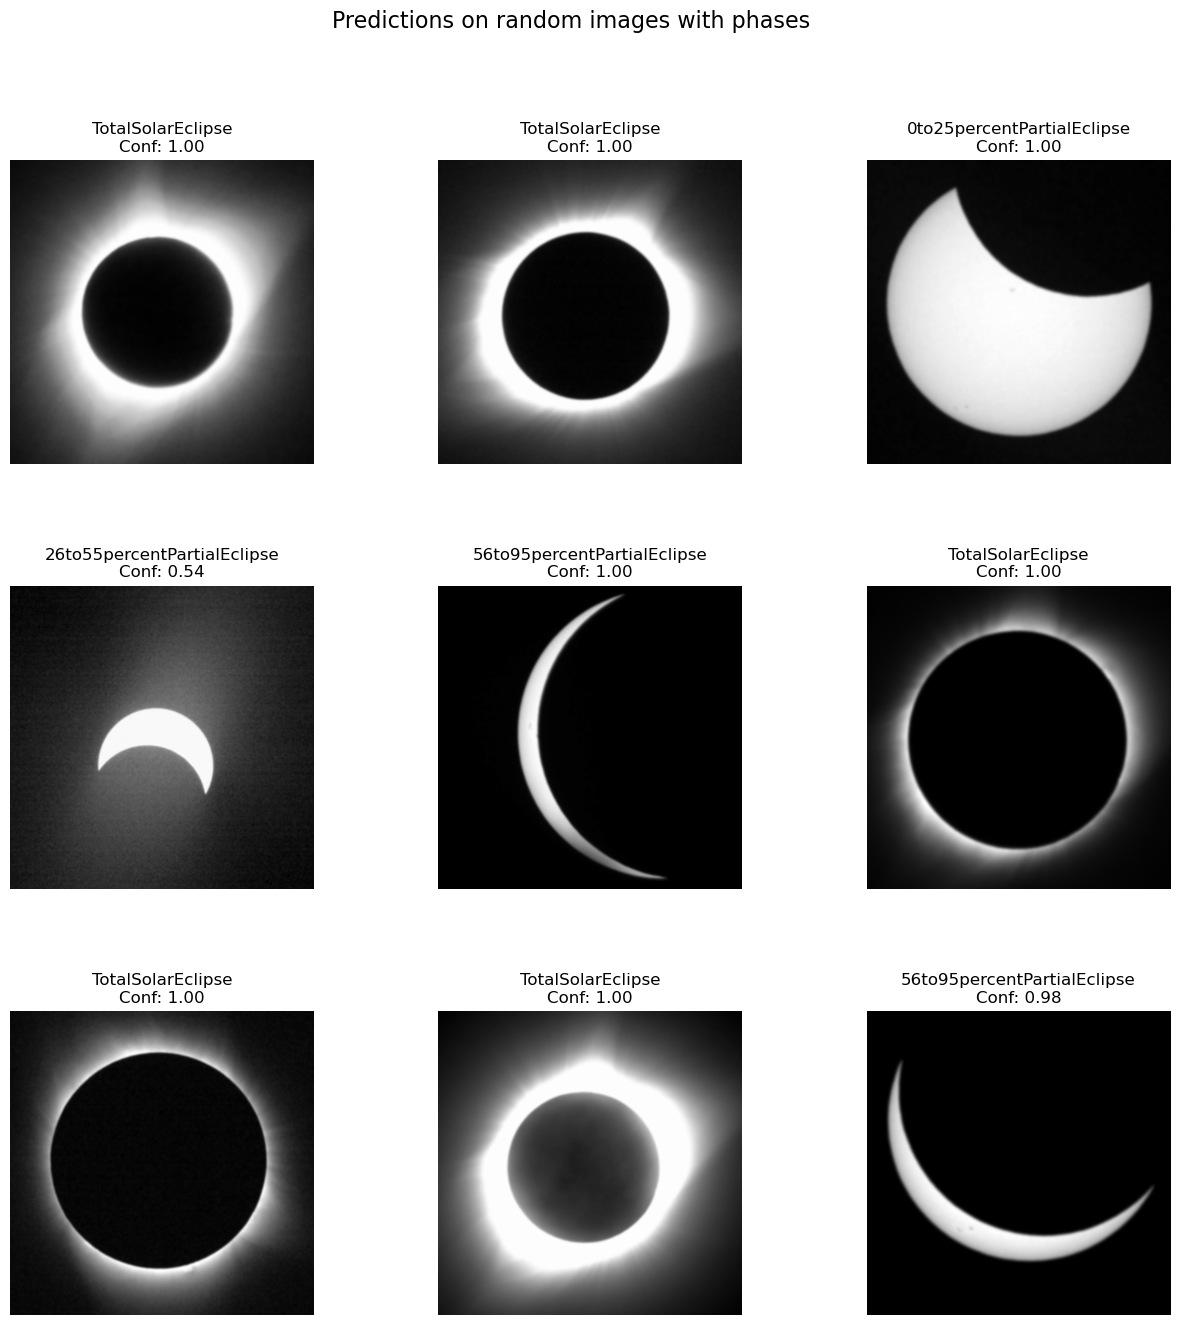

In [76]:
label_map_path = r"eclipse-megamovie/label_num_to_phase_map.json"

with open(label_map_path, "r") as file:
    label_num_to_phase_map = {v: k for k, v in json.load(file).items()}

def display_predictions(dataset, predictions, num_images=9):
    sample_preds = random.sample(predictions, min(num_images, len(predictions)))

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle("Predictions on random images with phases", fontsize=16)
    axes = axes.flatten()
    
    for ax, (img_name, label, confidence) in zip(axes, sample_preds):
        img_path = os.path.join(dataset.image_folder, img_name)
        image = Image.open(img_path)
        phase_description = label_num_to_phase_map.get(label, "Unknown")
        ax.imshow(image, cmap="gray")
        ax.set_title(f"{phase_description}\nConf: {confidence:.2f}")
        ax.axis("off")

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

display_predictions(test_dataset, predictions)

# Histograms classification 

In [77]:
def gaussdx(sigma: float) -> Tuple[np.ndarray, np.ndarray]:
    
    sigma = math.ceil(sigma)
    filter_size = 6 * sigma + 1

    zero_pos = filter_size //2
    x = np.arange(filter_size) - zero_pos

    Dx = (-x) * np.exp(-(x**2) / (2.0 * sigma**2)) / (math.sqrt(2.0 * np.pi) * sigma**3)

    return Dx, x

In [78]:
def gauss_dxdy(img: np.ndarray, sigma: float) -> Tuple[np.ndarray, np.ndarray]:
    
    Dx, _ = gaussdx(sigma)
    img_Dx = convolve1d(img, Dx, axis=1)
    img_Dy = convolve1d(img, Dx, axis=0)

    return img_Dx, img_Dy

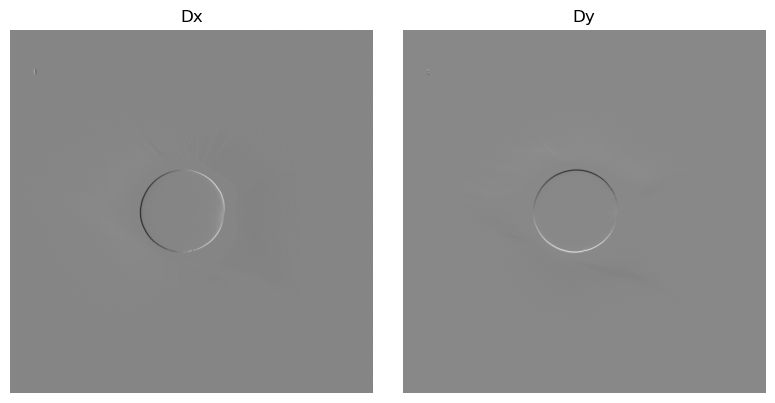

In [79]:
img_color = rgb2gray(np.array(Image.open("eclipse-megamovie/test/0083b50624b619bb66705581d5c08e6fc2dc77574a979835ef01f96f9f19f8b1.jpg")))

img_Dx, img_Dy = gauss_dxdy(img_color, 1)

plot_pictures([img_Dx, img_Dy], ["Dx", "Dy"], 1, 2)

In [80]:
def hist_dxdy(img_gray, num_bins=5):
    
    sigma = 3.0
    img_dx, img_dy = gauss_dxdy(img_gray, sigma)

    min_der, max_der = (-6, 6)

    img_dx = img_dx.reshape(-1)
    img_dy = img_dy.reshape(-1)
    
    img_dx = np.clip(img_dx, min_der, max_der) - min_der
    img_dy = np.clip(img_dy, min_der, max_der) - min_der

    hists = np.zeros((num_bins, num_bins), dtype=float)
    bin_range = (max_der - min_der) / num_bins

    bin_dx = np.floor(img_dx / bin_range).astype(int)
    bin_dy = np.floor(img_dy / bin_range).astype(int)
    bin_dx = np.clip(bin_dx, 0, num_bins - 1)
    bin_dy = np.clip(bin_dy, 0, num_bins - 1)

    for i in range(bin_dx.size):
        hists[bin_dx[i], bin_dy[i]] += 1

    hists /= hists.sum()
    hists = hists.flatten()
    return hists

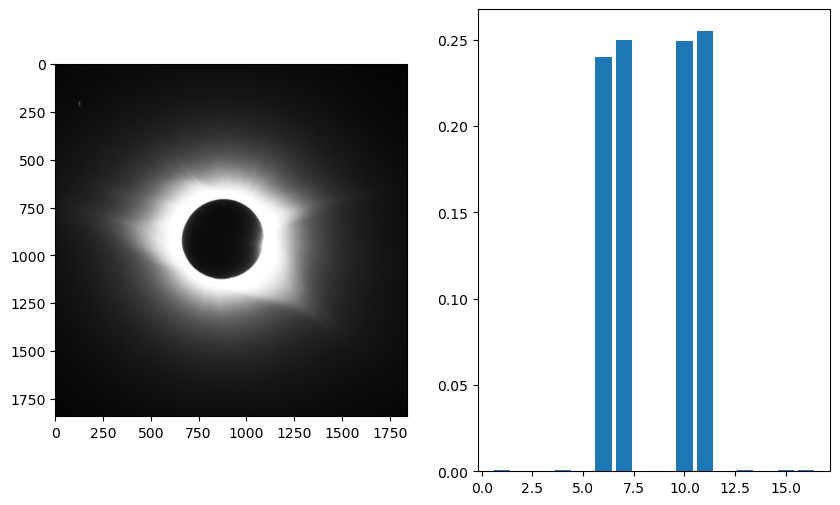

In [81]:
img_color = np.array(Image.open("eclipse-megamovie/test/0083b50624b619bb66705581d5c08e6fc2dc77574a979835ef01f96f9f19f8b1.jpg"))
img_gray = rgb2gray(img_color.astype("double"))

plt.figure(5, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_gray)

num_bins_dxdy = 4
plt.subplot(1, 2, 2)
hist_dxdy_ = hist_dxdy(img_gray, num_bins_dxdy)
plt.bar(np.array(range(1, hist_dxdy_.size + 1)), hist_dxdy_)
plt.show()

In [82]:
def hist_intersect(h1: np.ndarray, h2: np.ndarray) -> float:
    
    min_sum = np.sum(np.minimum(h1, h2))
    x = 0.5 * (min_sum / np.sum(h1) + min_sum / np.sum(h2))
    
    return x

def hist_l2(h1: np.ndarray, h2: np.ndarray) -> float:
    
    x = (np.sqrt(np.sum((h1-h2)**2)))
    
    return x


def hist_chi2(h1: np.ndarray, h2: np.ndarray) -> float:

    eps = 1 
    x = np.sum((h1 - h2)**2 / (h1 + h2 + eps)) 
  
    return x

def hist_ce(h1: np.ndarray, h2: np.ndarray) -> float:
    
    tmp = []
    for i in range(len(h1)):
        if h2[i] == 0:
            tmp.append(0)
        else:
            tmp.append(h1[i] * np.log(h2[i]))
    ce = -sum(tmp)
    return ce

In [83]:
def is_grayvalue_hist(hist_name: str) -> bool:

    if hist_name == "grayvalue" or hist_name == "dxdy":
        return True
    elif hist_name == "rgb" or hist_name == "gb":
        return False
    else:
        assert False, "unknown histogram type"


def get_hist_by_name(img: np.ndarray, num_bins_gray: int, hist_name: str) -> np.ndarray:

    if hist_name == "dxdy":
        return hist_dxdy(img, num_bins_gray)
    else:
        assert False, "unknown hist type: %s" % hist_name


def get_dist_by_name(x: np.ndarray, y: np.ndarray, dist_name: str) -> float:

    if dist_name == "chi2":
        return hist_chi2(x, y)
    elif dist_name == "intersect":
        return 1 - hist_intersect(x, y)
    elif dist_name == "l2":
        return hist_l2(x, y)
    elif dist_name == "ce":
        return hist_ce(x, y)
    elif dist_name == "all":
        pass
    else:
        assert False, "unknown distance: %s" % dist_name
        
def write_files(folder_path, output_file):

    image_extensions = {".jpg", ".jpeg", ".png"}

    try:
        if not os.path.isdir(folder_path):
            print(f"Error: Folder {folder_path} does not exist.")
            return

        files = os.listdir(folder_path)
        image_files = [file for file in files if os.path.splitext(file)[1].lower() in image_extensions]
        with open(output_file, "w") as f:
            for image_name in image_files:
                f.write("train_preprocessed/" + image_name + "\n")

        print(f"List of images saved in {output_file}.")
    except Exception as e:
        print(f"An error occurred: {e}")

write_files("train_preprocessed","model.txt")
        

def read_files(
    model_path: str = "model.txt", query_path: str = "query.txt"
) -> Tuple[List[str], List[str]]:
    with open(model_path) as fp:
        model_images = fp.readlines()
    model_images = [x.strip() for x in model_images]

    with open(query_path) as fp:
        query_images = fp.readlines()
    query_images = [x.strip() for x in query_images]

    return query_images, model_images

List of images saved in model.txt.


In [84]:
def compute_histograms(
    image_list: List[np.ndarray], hist_type: str, hist_isgray: bool, num_bins: int
) -> List[np.ndarray]:

    image_hist = []
    for img in image_list:
        if hist_isgray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)     
        img = img.astype(np.float32)
        if img.dtype != np.float32:
            raise ValueError(f"Image dtype is {img.dtype}, expected float32.")

        hist = get_hist_by_name(img, num_bins, hist_type)
        image_hist.append(hist)

    return image_hist


def find_best_match(
    train_images: List[str],
    dist_type: str,
    hist_type: str,
    num_bins: int,
) -> Tuple[np.ndarray, np.ndarray]:

    train_imgs = [cv2.imread(img) for img in train_images]

    hist_isgray = is_grayvalue_hist(hist_type)
    train_hist = compute_histograms(train_imgs, hist_type, hist_isgray, num_bins)

    D = np.zeros((len(train_imgs), len(train_imgs)))

    for i, m in enumerate(train_hist):
        for j, q in enumerate(train_hist):
            if i == j:
                continue
            dist_value = get_dist_by_name(m, q, dist_type)
            D[i, j] = dist_value

    return D


In [85]:
query_images, model_images = read_files()

dist_type = "chi2"
hist_type = "dxdy"
num_bins = 8

df = pd.read_csv("eclipse-megamovie/train.csv")
y_true = df["label"].to_numpy()

D = find_best_match(
 model_images, dist_type, hist_type, num_bins
)

In [100]:
def show_neighbors(
    train_images: List[str],
) -> None:

    for i in range(0,5):
        sorted_indices = np.argsort(D[:, i])[:5]
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 6, 1)
        query_img = plt.imread(train_images[i])
        plt.imshow(query_img)
        plt.title('Training image')
        plt.axis('off')

        for idx, j in enumerate(sorted_indices):
            if j == i:
                continue
            plt.subplot(1, 6, idx + 2)
            img = plt.imread(train_images[j])
            plt.imshow(img)
            matching_value = D[j, i]
            plt.title(f' {matching_value:.4f}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [101]:
def calculate_label(
    train_images: List[str],
    D: np.ndarray,
    csv_file: str
) -> Tuple[Dict[str, str], Dict[str, str]]:

    df = pd.read_csv(csv_file)
    label_dict = {os.path.basename(row['image_id']): row['label'] for index, row in df.iterrows()}

    y_true = {}
    y_pred = {}

    for i in range(len(train_images)):
        sorted_indices = np.argsort(D[:, i])[:5]
        query_img_name = os.path.basename(train_images[i])
        query_label = label_dict.get(query_img_name, "Unknown")
        y_true[query_img_name] = query_label

        closest_idx = sorted_indices[1]
        closest_img_name = os.path.basename(train_images[closest_idx])
        closest_img_label = label_dict.get(closest_img_name, "Unknown")

        y_pred[query_img_name] = closest_img_label

    return y_true, y_pred

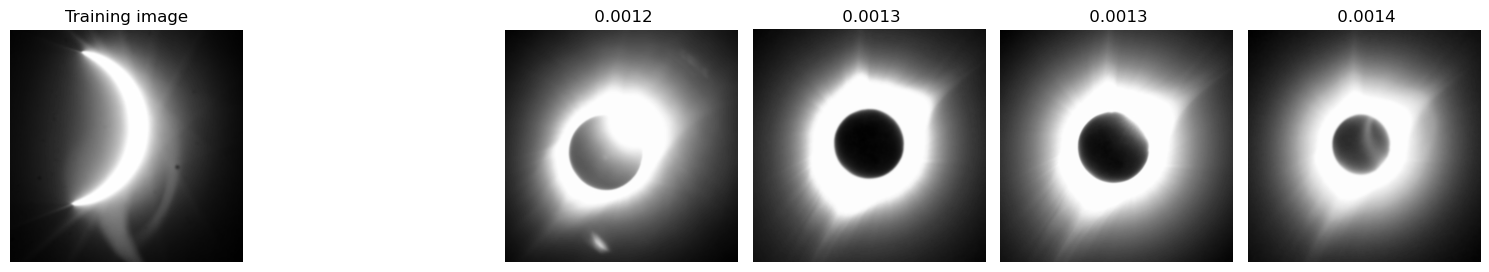

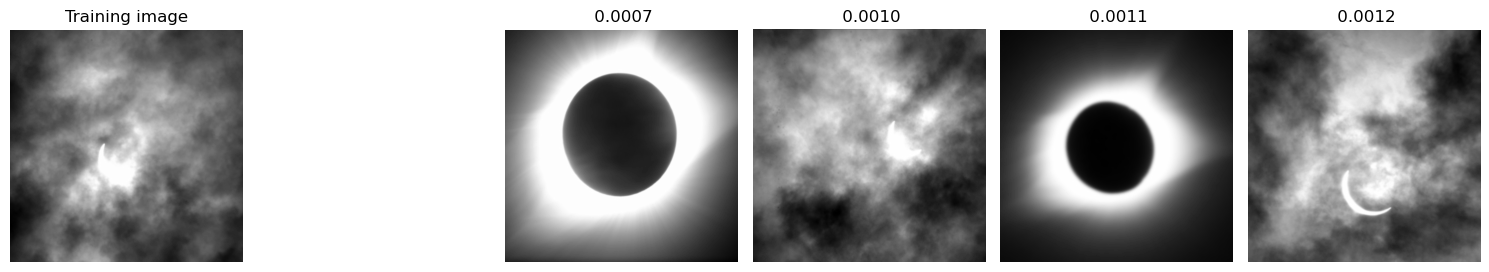

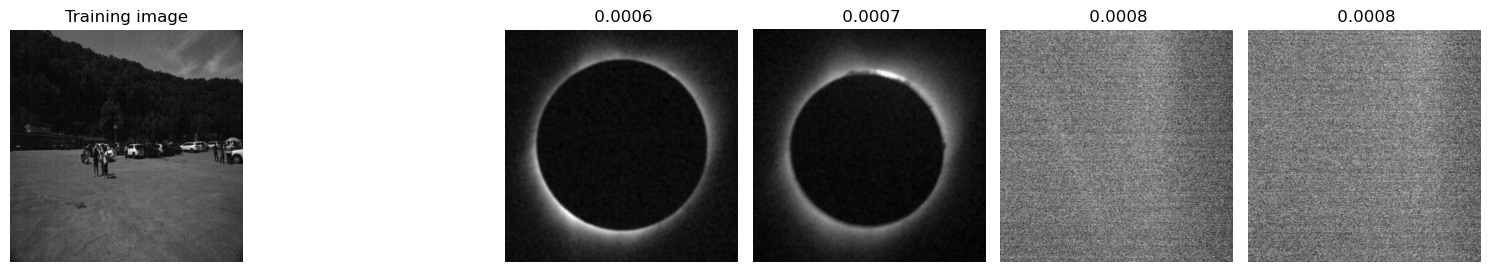

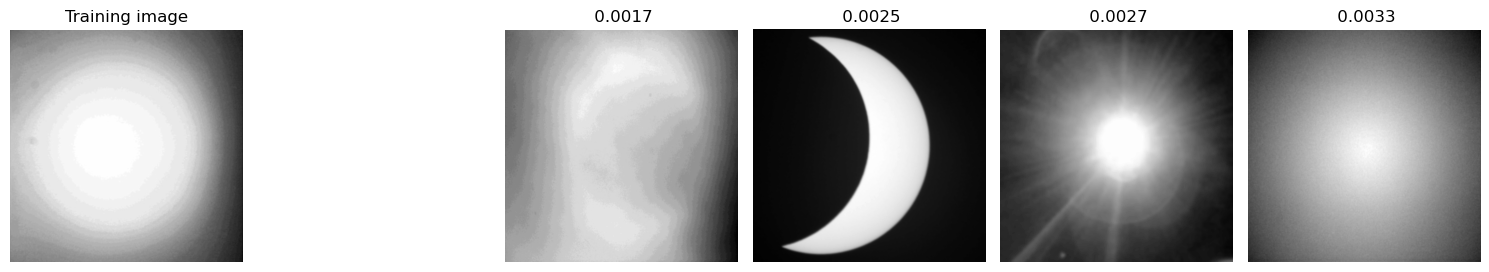

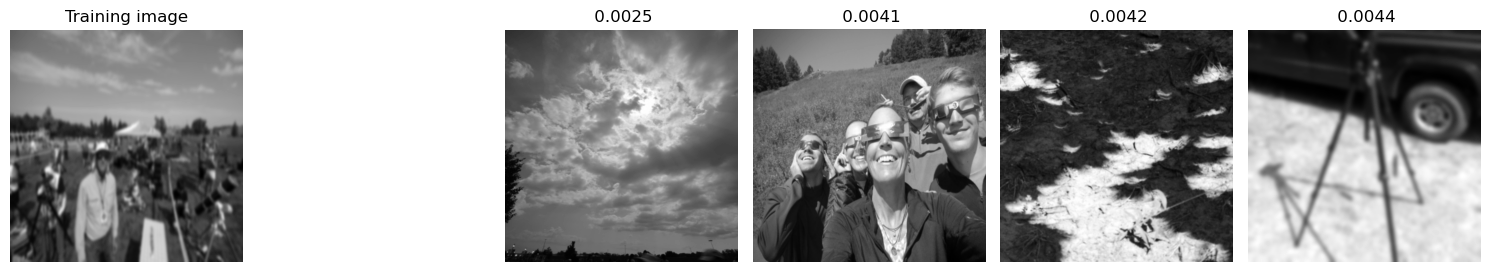

In [102]:
query_images_vis = [model_images[i] for i in np.array([1, 2])]

show_neighbors(model_images)
y_pred, y_true =  calculate_label(model_images,D,"eclipse-megamovie/train.csv")

In [89]:
def calculate_accuracy(y_true, y_pred):
    correct = 0
    total = 0
    
    for key in y_true:
        if key in y_pred:
            total += 1
            if y_true[key] == y_pred[key]:
                correct += 1
    
    accuracy = correct / total if total > 0 else 0
    return accuracy

In [ ]:
accuracy = calculate_accuracy(y_true,y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.694949494949495.
